We aim to control the motion of the double pendulum around the balanced state. For that, we linearize the full dynamics
$$\dot{x} = \begin{pmatrix} \dot{q} \\ \dot{v} \end{pmatrix} = \begin{pmatrix} v \\ f(x) \end{pmatrix}$$ with $$f(x)=M^{-1}(q) \big[ C(q,v) + g(q) - Kq \big] $$ around the unstable fixpoint $x^*=(\phi_1,\phi_2,\dot{\phi_1},\dot{\phi_2})=(\pi,0,0,0)$. We need to calculate the Jacobian
$$A_{x^*}(x) = \frac{\partial f(x)}{ \partial x}\biggr\rvert_{x^*}.$$
of the linear system $\dot{x}=Ax$. It contains the stiffness and damping matrices $K$ and $B$ as
$$ A = \begin{pmatrix} 0 & I \\ -K & -B \end{pmatrix}. $$
The solutions of linear system are
$$ x(t)=e^{At}x_0, $$
where $x_0$ is the initial state.


In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from dynamics_hybrid import f, rphi_to_q, drphi_to_dq
from integrate import forward,make_stepper,linearize_discrete
from plotting import plot_solution, show_pendulum, plot_eigs_unit_circle

In [2]:
#SET INITIAL STATE

#define in rphi coordinates
p = ca.DM([1,2,0.5,0,0,0,9.81]) #parameters: [m,M,l,k,kappa,J,g]
c_init = ca.DM([1,0]) #tip 1 in contact
rtip = ca.DM([0.25,0]) #contact position (z coordinate is forced to zero if c is (1,0) or (0,1))
phi = ca.DM([np.pi/42,np.pi/8])
#phi = ca.DM([np.pi/100,np.pi/16])

#convert to q coordinates
rphi_to_q = rphi_to_q.expand()
q_init = rphi_to_q(c_init,rtip,phi,p)

#build initial state vector
v_init = ca.DM.zeros(4)
x_init = ca.vertcat(q_init,v_init)
print(x_init)

[0.230188, 0.258466, 0.233749, 0.317899, 0, 0, 0, 0]


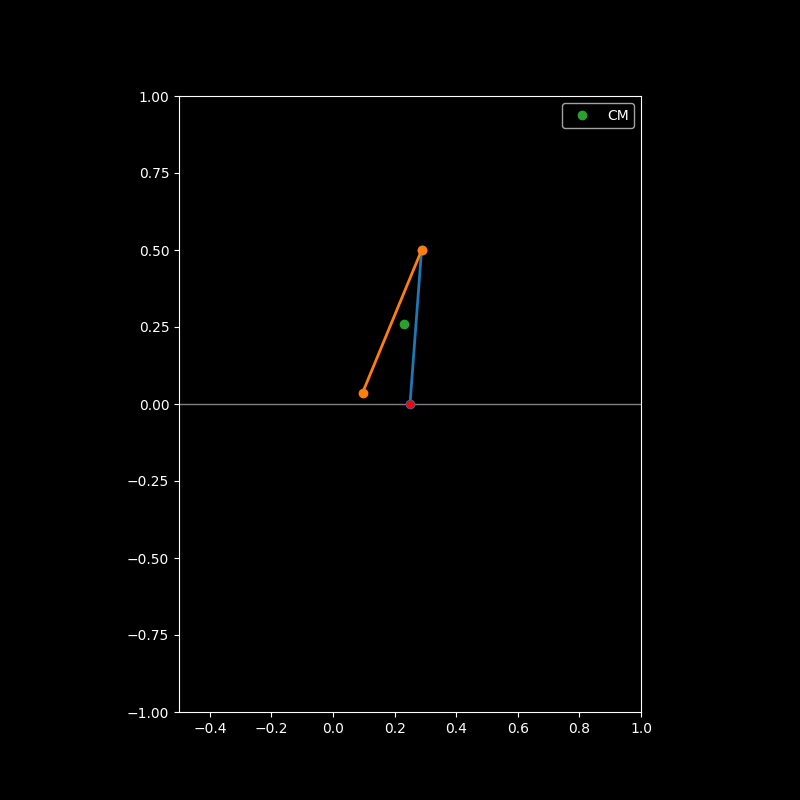

In [3]:
#NONLINEAR ZERO DYNAMICS

dt = 0.02
N = 100
u_init = ca.DM.zeros(N,1)
X,ts,C,_,_ = forward(x_init, u_init, p, dt, N, c_init, f_dyn=f)
show_pendulum(X, C[:,0], C[:,1], dt, p_val=p, gif_path="motion.gif")

In [4]:
#LINEAR ZERO DYNAMICS AROUND STANDING CONFIGURATION

#get Jacobians as an expression
F = make_stepper(f, dt)
A_func, B_func = linearize_discrete(F)

x_d = ca.DM.zeros(1,8)     # linearization point
u_d = ca.DM.zeros(1,1)

A = A_func(x_d, u_d, p, c_init[0], c_init[1])
B = B_func(x_d, u_d, p, c_init[0], c_init[1])

# deviations
dx = ca.DM.zeros(N+1,8)
du = ca.DM.zeros(N,1)

dx[:,0] = x_init - x_d
for k in range(N):
    dx[:,k+1] = ca.mtimes(A, dx[:,k]) + ca.mtimes(B, du[:,k])

# reconstructed state
x = np.array(ca.repmat(x_d, 1, N+1) + dx)
u = np.array(ca.repmat(u_d, 1, N) + du)
t = np.linspace(0,N*dt,N+1)
plot_solution(t,x,u,X)

RuntimeError: .../casadi/core/matrix_impl.hpp:1386: Dimension mismatch for (x-y), x is 8x1, while y is 1x8

In [ ]:
#BALANCING IN STANDING CONFIGURATION (LQR)

from scipy.linalg import solve_discrete_are

A = A_func(x_d, u_d, p, c_init[0], c_init[1])
B = B_func(x_d, u_d, p, c_init[0], c_init[1])
print('Shape of full A:', A.shape)
print('Shape of full B:', B.shape)

# take controllable part of state: [qmean,qrel,dqmean,dqrel]
idx = [2,3,6,7]
A_ctrl = np.array(A)[np.ix_(idx, idx)]
B_ctrl = np.array(B)[np.ix_(idx, [0])]
print('Shape of controllable A:', A.shape)
print('Shape of controllable B:', B.shape)

Q = np.diag([30,30,1,1])
R = np.array([[1.0]])

P = solve_discrete_are(A_ctrl, B_ctrl, Q, R)
K = np.linalg.solve(R + B_ctrl.T @ P @ B_ctrl, B_ctrl.T @ P @ A_ctrl)

K = ca.DM(K) #convert back to casadi format
print('Shape of feedback gain K:',K.shape)

u_init = 0
dx[:,0] = x_init - x_d
du[:,0] = 0 - u_d
for k in range(N): #feedback control loop
    du[:,k] = - K @ dx[idx,k] #controls are chosen only from the controllable state part
    dx[:,k+1] = ca.mtimes(A, dx[:,k]) + ca.mtimes(B, du[:,k])

# reconstructed linear state
x = np.array(ca.repmat(x_d, 1, N+1) + dx)
u = np.array(ca.repmat(u_d, 1, N) + du)
t = np.linspace(0,N*dt,N+1)

#actuation of nonlinear system with LQR gain
X, ts, C, k_td,_ = forward(x_init, u, p, dt, N, c_init, f_dyn=f)
plot_solution(ts,x,u,X)
show_pendulum(X, C[:,0], C[:,1], dt, p_val=p, gif_path="motion.gif")

In [ ]:
#FREQUENCY ANALYSIS AT STANDING CONFIGURATION

from scipy.linalg import eig

print(A_ctrl.shape)
evals,evecs = eig(A_ctrl)
plot_eigs_unit_circle(evals, title="A_ctrl eigenvalues")
plt.show()
print(evals)

In [ ]:
N=200

#pick eval with largest positive imag part and calculate corresponding freq
id_eig = np.argmax(np.abs(np.imag(evals)))
freq = np.angle(evals[id_eig]) / (2*np.pi*dt)
T_period = 1/abs(freq)
N_period = T_period/dt
print(freq,T_period,N_period)

#construct initial state from corresponding evec
evec_norm = np.real(evecs[:,id_eig] / np.linalg.norm(evecs[:,id_eig]))
print(evec_norm) #we see that the eigenmode has zero q but nonzero dq

#we need to convert to phi coords and then back to get a state consistent with the constraints
def construct_init(evec,amp,c_init,rtip,p):
    qmean,qrel,dqmean,dqrel = amp * np.real(evec / np.linalg.norm(evec))
    phi1 = qmean - qrel/2
    phi2 = qmean + qrel/2
    phi = np.array([phi1,phi2])
    dphi1 = dqmean - dqrel/2
    dphi2 = dqmean + dqrel/2
    dphi = np.array([dphi1,dphi2])
    q_init = rphi_to_q(c_init,rtip,phi,p)
    dq_init = drphi_to_dq(c_init,dphi,q_init,p)
    x_init = ca.vertcat(q_init,dq_init)
    return x_init

amp = np.pi/2
x_init = construct_init(evecs[:,id_eig],amp,c_init,rtip,p)
print(x_init)

In [ ]:
x_d = ca.DM.zeros(8,1)
u_d = ca.DM([0])
dx = ca.DM.zeros(8, N+1)
du = ca.DM.zeros(1, N)

dx[:,0] = x_init - x_d
du = 0 - u_d
for k in range(N):
    dx[:,k+1] = ca.mtimes(A, dx[:,k])

# reconstructed linear state
x = np.array(ca.repmat(x_d, 1, N+1) + dx)
u = np.array(ca.repmat(u_d, 1, N) + du)
t = np.linspace(0,N*dt,N+1)

#nonlinear system
X, ts, C, k_td,_ = forward(x_init, u, p, dt, N, c_init, f_dyn=f)
plot_solution(ts,x,u,X)
show_pendulum(X, C[:,0], C[:,1], dt, p_val=p, gif_path="motion.gif")